In [1]:
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import SeasonalAD
from adtk.detector import AutoregressionAD
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import os

In [2]:
sample = pd.read_csv('../data/sample3.csv')

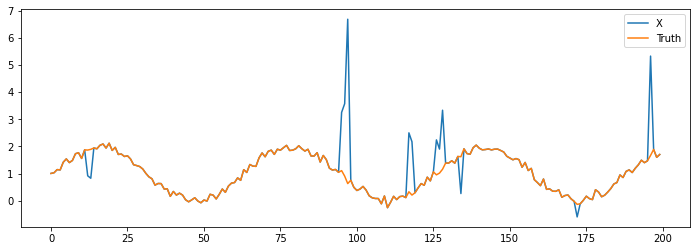

In [3]:
plt.figure(figsize=(12, 4))
sample[:200].plot(ax=plt.gca())
plt.legend()
plt.show()

In [4]:
ds = [pd.to_datetime('2020-01-01')]
for i in range(sample.shape[0]-1):
    ds.append(ds[-1] + pd.offsets.Day(1))

df = pd.DataFrame({'y': sample.X.values}, index=ds)
df

y
2020-01-01  1.002849
2020-01-02  1.028838
2020-01-03  1.144016
2020-01-04  1.133551
2020-01-05  1.415878
...              ...
2025-06-18  0.235249
2025-06-19  0.048924
2025-06-20  0.075755
2025-06-21  0.023985
2025-06-22  0.046545

[2000 rows x 1 columns]

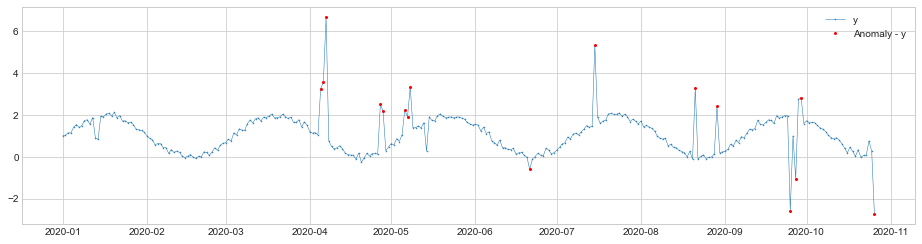

In [5]:
df = validate_series(df)
seasonal_ad = SeasonalAD(c=1, side="both")
anomalies = seasonal_ad.fit_detect(df)
plot(
    df[:300], 
    anomaly=anomalies[:300], 
    ts_markersize=1, 
    anomaly_color='red', 
    anomaly_tag="marker", 
    anomaly_markersize=2
)

In [6]:
def clean(X):
    X_clean = X.copy()
    
    ds = [pd.to_datetime('2020-01-01')]
    for i in range(X_clean.shape[0]-1):
        ds.append(ds[-1] + pd.offsets.Day(1))

    df = pd.DataFrame({'y': X_clean}, index=ds)
    df = validate_series(df)
    seasonal_ad = SeasonalAD(c=1, side="both")
    anomalies = seasonal_ad.fit_detect(df)
    X_clean = df[anomalies != True]['y'].values
    X_clean = pd.Series(X_clean).interpolate().values
    X_clean = pd.Series(X_clean).fillna(method='ffill').values
    X_clean = pd.Series(X_clean).fillna(method='bfill').values
    return X_clean

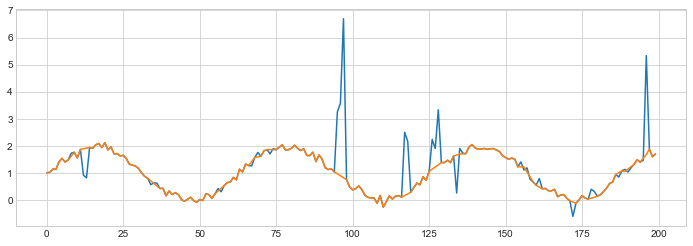

In [7]:
plt.figure(figsize=(12, 4))
plt.plot(sample.X.values[:200])
plt.plot(clean(clean(sample.X.values[:200])))
plt.show()

In [8]:
def get_files_list(path):
    files = []
    for aname in os.listdir(path):
        if (aname[-3:] == "csv") or (aname[-3:] == "txt"): 
            files.append(os.path.join(path, aname))
    return files

def run_tests(dir_path):
    
    print("Dataset: ", dir_path)
    files = get_files_list(dir_path)
    files.sort()
    
    report = pd.DataFrame(columns=["Sample", "RMSE"])
    
    for afile in files:
        
        print("File: ", afile)
            
        data = pd.read_csv(afile, index_col=False)
        
        X      = data['X'].values
        X_true = data['Truth'].values
        
        X_clean = clean(clean(X))
        
        rmse = mean_squared_error(X_true, X_clean, squared=False)
        
        report.loc[len(report)] = [afile, rmse]
        print("RMSE: ", rmse)
            
    return report

In [9]:
report = run_tests('../data/')
report

Dataset:  ../data/
File:  ../data/sample1.csv


Exception: Could not find significant seasonality.

In [10]:
def clean(X):
    X_clean = X.copy()
    
    ds = [pd.to_datetime('2020-01-01')]
    for i in range(X_clean.shape[0]-1):
        ds.append(ds[-1] + pd.offsets.Day(1))

    df = pd.DataFrame({'y': X_clean}, index=ds)
    df = validate_series(df)
    autoregression_ad = AutoregressionAD(n_steps=3, step_size=3, c=3.0)
    anomalies = autoregression_ad.fit_detect(df)
    X_clean = df[anomalies != True]['y'].values
    X_clean = pd.Series(X_clean).interpolate().values
    X_clean = pd.Series(X_clean).fillna(method='ffill').values
    X_clean = pd.Series(X_clean).fillna(method='bfill').values
    return X_clean

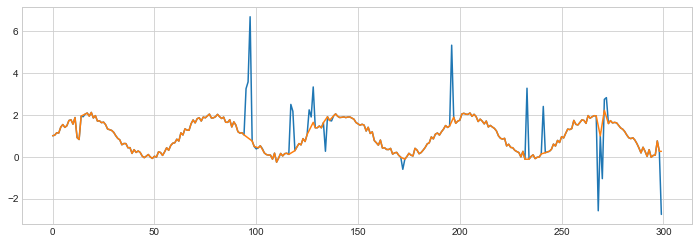

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(sample.X.values[:300])
plt.plot(clean(clean(sample.X.values[:300])))
plt.show()

In [12]:
report = run_tests('../data/')
report

Dataset:  ../data/
File:  ../data/sample1.csv
RMSE:  0.12149857755020195
File:  ../data/sample2.csv
RMSE:  0.08736486191180359
File:  ../data/sample3.csv
RMSE:  0.1658550905885431
File:  ../data/sample4.csv
RMSE:  0.22248726375961056
File:  ../data/sample5.csv
RMSE:  0.23103406673605886
File:  ../data/sample6.csv
RMSE:  2.4000786103821063
File:  ../data/sample7.csv
RMSE:  7.232530379897539
File:  ../data/sample8.csv
RMSE:  1.4399663768262818
File:  ../data/sample9.csv
RMSE:  95.43822221260415


Sample       RMSE
0  ../data/sample1.csv   0.121499
1  ../data/sample2.csv   0.087365
2  ../data/sample3.csv   0.165855
3  ../data/sample4.csv   0.222487
4  ../data/sample5.csv   0.231034
5  ../data/sample6.csv   2.400079
6  ../data/sample7.csv   7.232530
7  ../data/sample8.csv   1.439966
8  ../data/sample9.csv  95.438222

In [13]:
board = pd.DataFrame(columns=['Data preparation', 'Model']+['sample'+str(i) for i in range(1, 10)])
board.loc[len(board)] = ['No', 'ADTK Autoregression'] + list(report['RMSE'].values)
board = board.set_index(['Data preparation', 'Model'])
board

sample1   sample2   sample3   sample4  \
Data preparation Model                                                         
No               ADTK Autoregression  0.121499  0.087365  0.165855  0.222487   

                                       sample5   sample6  sample7   sample8  \
Data preparation Model                                                        
No               ADTK Autoregression  0.231034  2.400079  7.23253  1.439966   

                                        sample9  
Data preparation Model                           
No               ADTK Autoregression  95.438222

In [14]:
board.to_csv('../results/no_adtk.csv')